# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)
print("Done.")

Found mnist Data
Found celeba Data
Done.


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

Done.


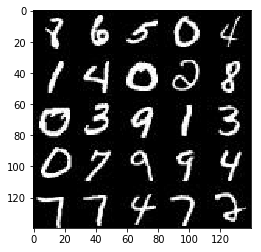

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
print("Done.")

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

Done.


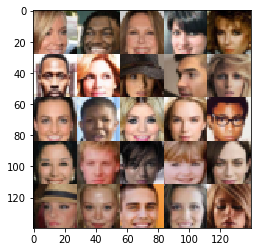

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))
print("Done.")

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
#if not tf.test.gpu_device_name():
#    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
#else:
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_in = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_in')
    z_in = tf.placeholder(tf.float32, (None, z_dim), name='z_in')
    learn_rate = tf.placeholder(tf.float32, name="learn_rate")
    return real_in, z_in, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)
print("Done.")

Tests Passed
Done.


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = .6
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 64 × 14 × 14
        conv_1 = tf.layers.conv2d(images, 
                                  filters=64, 
                                  kernel_size=5, 
                                  strides=2,
                                  padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1 = tf.maximum(alpha * conv_1, conv_1)
        drop_1 = tf.layers.dropout(relu_1, keep_prob)
        
        # 128 × 7 × 7
        conv_2 = tf.layers.conv2d(drop_1, 
                                  filters=128, 
                                  kernel_size=5, 
                                  strides=2,
                                  padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_2 = tf.layers.batch_normalization(conv_2)
        relu_2 = tf.maximum(alpha * conv_2, conv_2)
        drop_2 = tf.layers.dropout(relu_2, keep_prob) 
        
        # 256 × 4 × 4
        conv_3 = tf.layers.conv2d(drop_2,
                                  filters=256,
                                  kernel_size=5,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_3 = tf.layers.batch_normalization(conv_3)
        relu_3 = tf.maximum(alpha * conv_3, conv_3)
        drop_3 = tf.layers.dropout(relu_3, keep_prob)
        
        flat_size = 256 * 4 * 4
        logits = tf.layers.dense(tf.reshape(drop_3, (-1, flat_size)), 1)
        outputs = tf.sigmoid(logits)
        
        return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)
print("Done.")

Tests Passed
Done.


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = .2
    keep_prob = .6
    reuse_vars = (not is_train)
    
    with tf.variable_scope('generator', reuse=reuse_vars):
        # 512 × 4 × 4
        full = tf.layers.dense(z, units=4*4*512)
        full = tf.reshape(full, (-1, 4, 4, 512))
        norm_1 = tf.layers.batch_normalization(full, training=is_train)
        relu_1 = tf.maximum(alpha * norm_1, norm_1)
        drop_1 = tf.layers.dropout(relu_1, keep_prob, training=is_train)
        
        # 128 × 4 × 4
        conv_2 = tf.layers.conv2d_transpose(drop_1, 
                                            filters=128, 
                                            kernel_size=4, 
                                            strides=1, 
                                            padding='valid')
        norm_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        relu_2 = tf.maximum(alpha * norm_2, norm_2)
        drop_2 = tf.layers.dropout(relu_2, keep_prob, training=is_train)
        
        # 64 × 7 × 7
        conv_3 = tf.layers.conv2d_transpose(drop_2, 
                                            filters=64, 
                                            kernel_size=5, 
                                            strides=2, 
                                            padding='same')
        norm_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        relu_3 = tf.maximum(alpha * norm_3, norm_3)
        drop_3 = tf.layers.dropout(relu_3, keep_prob, training=is_train)
        
        # 32 × 14 × 14
        conv_4 = tf.layers.conv2d_transpose(drop_3, 
                                            filters=32, 
                                            kernel_size=5, 
                                            strides=2, 
                                            padding='same')
        norm_4 = tf.layers.batch_normalization(conv_4, training=is_train)
        relu_4 = tf.maximum(alpha * norm_4, norm_4)
        drop_4 = tf.layers.dropout(relu_4, keep_prob, training=is_train)
        
        # out_channel_dim × 28 × 28
        logits = tf.layers.conv2d_transpose(drop_4, 
                                            filters=out_channel_dim, 
                                            kernel_size=3, 
                                            strides=1,
                                            padding='same')
        outputs = tf.tanh(logits)
        
        return outputs
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)
print("Done.")

Tests Passed
Done.


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_out = generator(input_z, out_channel_dim)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False)
    disc_fake_out, disc_fake_logits = discriminator(gen_out, reuse=True)
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_fake_logits, 
            labels=tf.ones_like(disc_fake_out)))
    disc_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_real_logits, 
            labels=tf.ones_like(disc_real_out) * 0.9))
    disc_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_fake_logits, 
            labels=tf.zeros_like(disc_fake_out)))
    disc_ttl_loss = disc_real_loss + disc_fake_loss
    
    return disc_ttl_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)
print("Done.")

Tests Passed
Done.


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_vars = list(filter(lambda v: v.name.startswith('generator'), tf.trainable_variables()))
        disc_vars = list(filter(lambda v: v.name.startswith('discriminator'), tf.trainable_variables()))
    
        gen_optimized = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_optimized = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

    return disc_optimized, gen_optimized
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)
print("Done.")

Tests Passed
Done.


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
print("Done.")

Done.


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print("BEGIN TRAINING...")
    
    width, height, depth = (data_shape[1], data_shape[2], data_shape[3])
    real_in, z_in, learnrate = model_inputs(width, height, depth, z_dim)
    disc_loss, gen_loss = model_loss(real_in, z_in, depth)
    disc_optimized, gen_optimized = model_opt(disc_loss, gen_loss, learnrate, beta1)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_cnt = 0
            for batch_images in get_batches(batch_size):
                batch_cnt += 1
                # TODO: Train Model
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                sess.run(disc_optimized, 
                         feed_dict={
                             real_in: 2*batch_images,
                             z_in: batch_z,
                             learnrate: learning_rate})
                sess.run(gen_optimized, 
                         feed_dict={
                             real_in: 2*batch_images,
                             z_in: batch_z,
                             learnrate: learning_rate})
                    
                if batch_cnt % 16 == 0:
                    cur_gen_loss = gen_loss.eval({z_in: batch_z})
                    cur_disc_loss = disc_loss.eval({z_in: batch_z, real_in: batch_images})
                    print("Epoch {}/{}, batch {}: gen_loss={:.4f} disc_loss={:.4f}"
                          .format(epoch_i+1, epoch_count, batch_cnt, cur_gen_loss, cur_disc_loss))
                
                if batch_cnt % 128 == 0:
                    show_generator_output(sess, 50, z_in, depth, data_image_mode)
        
            print("Epoch {}/{}, batch {}: gen_loss={:.4f} disc_loss={:.4f}"
                          .format(epoch_i+1, epoch_count, batch_cnt, cur_gen_loss, cur_disc_loss))
            cur_disc_loss = disc_loss.eval({z_in: batch_z, real_in: batch_images})
                    
    print("TRAINING COMPLETE.")
                
print("Done.")

Done.


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

BEGIN TRAINING...
Epoch 1/2, batch 16: gen_loss=2.8189 disc_loss=0.6281
Epoch 1/2, batch 32: gen_loss=2.0075 disc_loss=0.8939
Epoch 1/2, batch 48: gen_loss=2.8745 disc_loss=0.8378
Epoch 1/2, batch 64: gen_loss=2.7949 disc_loss=0.7619
Epoch 1/2, batch 80: gen_loss=3.2618 disc_loss=0.6029
Epoch 1/2, batch 96: gen_loss=4.5424 disc_loss=0.7737
Epoch 1/2, batch 112: gen_loss=1.0564 disc_loss=1.0503
Epoch 1/2, batch 128: gen_loss=3.0247 disc_loss=0.8234


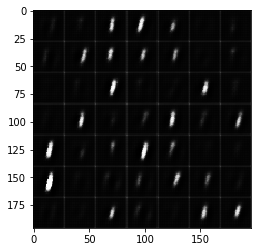

Epoch 1/2, batch 144: gen_loss=3.4964 disc_loss=0.8583
Epoch 1/2, batch 160: gen_loss=3.5376 disc_loss=1.1348
Epoch 1/2, batch 176: gen_loss=3.4244 disc_loss=1.5320
Epoch 1/2, batch 192: gen_loss=2.2105 disc_loss=1.1233
Epoch 1/2, batch 208: gen_loss=2.4304 disc_loss=1.1589
Epoch 1/2, batch 224: gen_loss=2.4682 disc_loss=1.3922
Epoch 1/2, batch 240: gen_loss=1.5015 disc_loss=1.1526
Epoch 1/2, batch 256: gen_loss=2.3698 disc_loss=0.8034


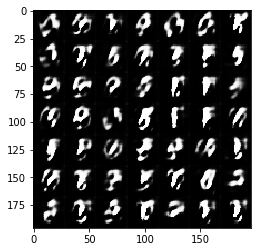

Epoch 1/2, batch 272: gen_loss=1.5345 disc_loss=1.0578
Epoch 1/2, batch 288: gen_loss=1.3543 disc_loss=1.3005
Epoch 1/2, batch 304: gen_loss=2.0501 disc_loss=1.1673
Epoch 1/2, batch 320: gen_loss=1.4223 disc_loss=1.5401
Epoch 1/2, batch 336: gen_loss=1.3497 disc_loss=1.7583
Epoch 1/2, batch 352: gen_loss=1.4698 disc_loss=1.4994
Epoch 1/2, batch 368: gen_loss=1.7497 disc_loss=2.3349
Epoch 1/2, batch 384: gen_loss=1.6533 disc_loss=2.2730


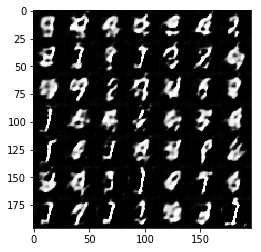

Epoch 1/2, batch 400: gen_loss=1.6126 disc_loss=2.2940
Epoch 1/2, batch 416: gen_loss=1.6775 disc_loss=2.3917
Epoch 1/2, batch 432: gen_loss=1.3374 disc_loss=2.7519
Epoch 1/2, batch 448: gen_loss=2.6701 disc_loss=3.1255
Epoch 1/2, batch 464: gen_loss=1.8684 disc_loss=1.3208
Epoch 1/2, batch 480: gen_loss=2.3210 disc_loss=2.0946
Epoch 1/2, batch 496: gen_loss=3.1491 disc_loss=3.3279
Epoch 1/2, batch 512: gen_loss=2.2424 disc_loss=3.4144


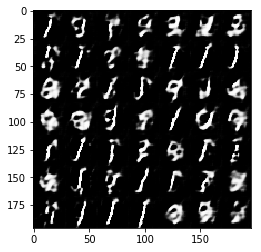

Epoch 1/2, batch 528: gen_loss=2.3730 disc_loss=3.6136
Epoch 1/2, batch 544: gen_loss=2.9235 disc_loss=3.2775
Epoch 1/2, batch 560: gen_loss=2.5410 disc_loss=4.3736
Epoch 1/2, batch 576: gen_loss=2.7028 disc_loss=4.3213
Epoch 1/2, batch 592: gen_loss=2.5292 disc_loss=4.1388
Epoch 1/2, batch 608: gen_loss=2.4808 disc_loss=4.1666
Epoch 1/2, batch 624: gen_loss=2.0317 disc_loss=3.3509
Epoch 1/2, batch 640: gen_loss=2.2301 disc_loss=3.9056


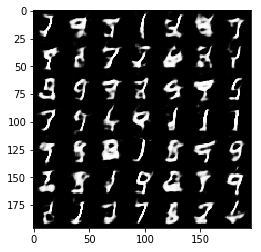

Epoch 1/2, batch 656: gen_loss=1.5625 disc_loss=3.6643
Epoch 1/2, batch 672: gen_loss=2.5786 disc_loss=3.0025
Epoch 1/2, batch 688: gen_loss=1.9898 disc_loss=3.3594
Epoch 1/2, batch 704: gen_loss=1.7072 disc_loss=3.7390
Epoch 1/2, batch 720: gen_loss=1.7062 disc_loss=4.2692
Epoch 1/2, batch 736: gen_loss=1.5750 disc_loss=3.4183
Epoch 1/2, batch 752: gen_loss=1.6100 disc_loss=4.2008
Epoch 1/2, batch 768: gen_loss=1.8551 disc_loss=2.7355


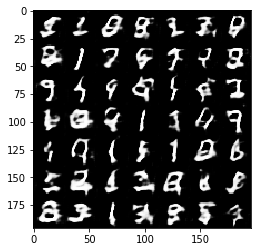

Epoch 1/2, batch 784: gen_loss=2.0116 disc_loss=3.7607
Epoch 1/2, batch 800: gen_loss=2.5660 disc_loss=4.4747
Epoch 1/2, batch 816: gen_loss=1.6893 disc_loss=4.8544
Epoch 1/2, batch 832: gen_loss=2.9507 disc_loss=5.5678
Epoch 1/2, batch 848: gen_loss=0.8997 disc_loss=3.3869
Epoch 1/2, batch 864: gen_loss=1.8733 disc_loss=4.4928
Epoch 1/2, batch 880: gen_loss=1.6300 disc_loss=5.0212
Epoch 1/2, batch 896: gen_loss=2.1398 disc_loss=3.2699


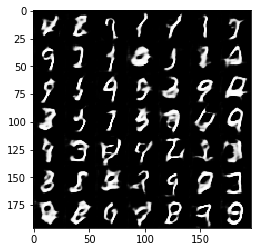

Epoch 1/2, batch 912: gen_loss=2.1880 disc_loss=5.1807
Epoch 1/2, batch 928: gen_loss=1.5760 disc_loss=4.7272
Epoch 1/2, batch 937: gen_loss=1.5760 disc_loss=4.7272
Epoch 2/2, batch 16: gen_loss=2.8348 disc_loss=5.8593
Epoch 2/2, batch 32: gen_loss=1.8770 disc_loss=5.0279
Epoch 2/2, batch 48: gen_loss=1.4123 disc_loss=4.0059
Epoch 2/2, batch 64: gen_loss=1.6730 disc_loss=5.2822
Epoch 2/2, batch 80: gen_loss=1.5356 disc_loss=4.0365
Epoch 2/2, batch 96: gen_loss=1.5027 disc_loss=4.7375
Epoch 2/2, batch 112: gen_loss=1.7654 disc_loss=4.9543
Epoch 2/2, batch 128: gen_loss=2.2916 disc_loss=5.7523


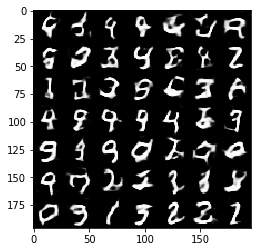

Epoch 2/2, batch 144: gen_loss=2.7008 disc_loss=6.0664
Epoch 2/2, batch 160: gen_loss=2.5693 disc_loss=5.8654
Epoch 2/2, batch 176: gen_loss=1.8910 disc_loss=5.4523
Epoch 2/2, batch 192: gen_loss=1.5055 disc_loss=4.9258
Epoch 2/2, batch 208: gen_loss=2.5804 disc_loss=5.6871
Epoch 2/2, batch 224: gen_loss=1.0845 disc_loss=4.3434
Epoch 2/2, batch 240: gen_loss=3.5900 disc_loss=6.4927
Epoch 2/2, batch 256: gen_loss=3.0914 disc_loss=6.0877


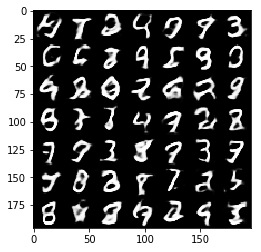

Epoch 2/2, batch 272: gen_loss=1.1840 disc_loss=5.0255
Epoch 2/2, batch 288: gen_loss=1.5332 disc_loss=5.3973
Epoch 2/2, batch 304: gen_loss=2.2606 disc_loss=5.3404
Epoch 2/2, batch 320: gen_loss=3.2447 disc_loss=5.6749
Epoch 2/2, batch 336: gen_loss=2.6287 disc_loss=5.8805
Epoch 2/2, batch 352: gen_loss=2.1844 disc_loss=6.3793
Epoch 2/2, batch 368: gen_loss=2.3556 disc_loss=5.3486
Epoch 2/2, batch 384: gen_loss=3.4725 disc_loss=6.7388


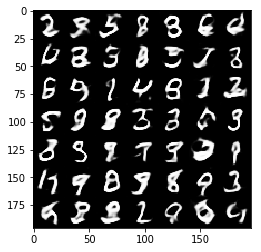

Epoch 2/2, batch 400: gen_loss=1.6259 disc_loss=5.0337
Epoch 2/2, batch 416: gen_loss=1.7923 disc_loss=5.5939
Epoch 2/2, batch 432: gen_loss=1.5790 disc_loss=4.7710
Epoch 2/2, batch 448: gen_loss=1.5187 disc_loss=5.3636
Epoch 2/2, batch 464: gen_loss=2.2490 disc_loss=5.5865
Epoch 2/2, batch 480: gen_loss=1.3951 disc_loss=5.2586
Epoch 2/2, batch 496: gen_loss=1.8081 disc_loss=5.7379
Epoch 2/2, batch 512: gen_loss=2.1701 disc_loss=5.5717


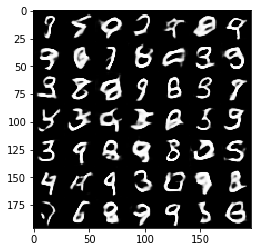

Epoch 2/2, batch 528: gen_loss=1.0976 disc_loss=5.0651
Epoch 2/2, batch 544: gen_loss=2.9079 disc_loss=5.9310
Epoch 2/2, batch 560: gen_loss=1.3229 disc_loss=5.5961
Epoch 2/2, batch 576: gen_loss=1.6140 disc_loss=5.6767
Epoch 2/2, batch 592: gen_loss=2.5079 disc_loss=5.6331
Epoch 2/2, batch 608: gen_loss=1.8197 disc_loss=5.7796
Epoch 2/2, batch 624: gen_loss=1.9004 disc_loss=5.6806
Epoch 2/2, batch 640: gen_loss=1.4452 disc_loss=4.5816


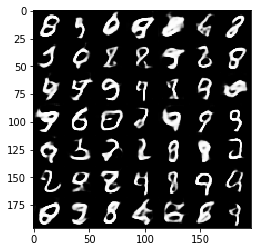

Epoch 2/2, batch 656: gen_loss=2.1758 disc_loss=5.9724
Epoch 2/2, batch 672: gen_loss=2.5065 disc_loss=6.4236
Epoch 2/2, batch 688: gen_loss=2.1850 disc_loss=5.6888
Epoch 2/2, batch 704: gen_loss=1.6257 disc_loss=5.4913
Epoch 2/2, batch 720: gen_loss=2.4579 disc_loss=6.3768
Epoch 2/2, batch 736: gen_loss=3.0870 disc_loss=6.2821
Epoch 2/2, batch 752: gen_loss=1.7945 disc_loss=5.3970
Epoch 2/2, batch 768: gen_loss=2.2960 disc_loss=5.8560


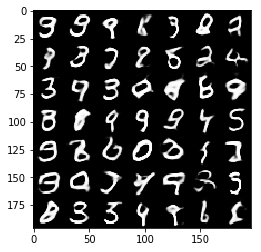

Epoch 2/2, batch 784: gen_loss=1.7862 disc_loss=5.4498
Epoch 2/2, batch 800: gen_loss=2.3752 disc_loss=6.0219
Epoch 2/2, batch 816: gen_loss=3.4478 disc_loss=7.2855
Epoch 2/2, batch 832: gen_loss=3.1764 disc_loss=6.8935
Epoch 2/2, batch 848: gen_loss=1.4499 disc_loss=5.5329
Epoch 2/2, batch 864: gen_loss=2.2697 disc_loss=6.0146
Epoch 2/2, batch 880: gen_loss=1.7266 disc_loss=5.2689
Epoch 2/2, batch 896: gen_loss=1.2476 disc_loss=5.6359


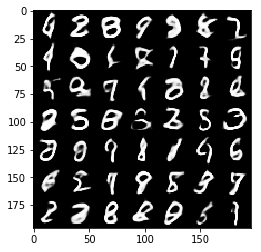

Epoch 2/2, batch 912: gen_loss=2.2347 disc_loss=6.0744
Epoch 2/2, batch 928: gen_loss=2.2411 disc_loss=5.3740
Epoch 2/2, batch 937: gen_loss=2.2411 disc_loss=5.3740
TRAINING COMPLETE.


In [24]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

BEGIN TRAINING...
Epoch 1/1, batch 16: gen_loss=3.2950 disc_loss=0.5092
Epoch 1/1, batch 32: gen_loss=2.9280 disc_loss=0.5417
Epoch 1/1, batch 48: gen_loss=4.6671 disc_loss=0.4614
Epoch 1/1, batch 64: gen_loss=3.9294 disc_loss=0.3950
Epoch 1/1, batch 80: gen_loss=5.0486 disc_loss=0.3804
Epoch 1/1, batch 96: gen_loss=2.8599 disc_loss=0.4296
Epoch 1/1, batch 112: gen_loss=4.0447 disc_loss=0.4022
Epoch 1/1, batch 128: gen_loss=5.8128 disc_loss=0.3873


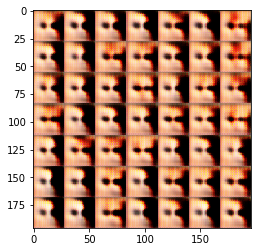

Epoch 1/1, batch 144: gen_loss=2.9759 disc_loss=0.5482
Epoch 1/1, batch 160: gen_loss=1.7625 disc_loss=0.6196
Epoch 1/1, batch 176: gen_loss=2.8510 disc_loss=0.6219
Epoch 1/1, batch 192: gen_loss=1.9155 disc_loss=0.6054
Epoch 1/1, batch 208: gen_loss=1.5757 disc_loss=0.7811
Epoch 1/1, batch 224: gen_loss=1.8412 disc_loss=0.7053
Epoch 1/1, batch 240: gen_loss=1.9265 disc_loss=0.7738
Epoch 1/1, batch 256: gen_loss=0.4512 disc_loss=1.5675


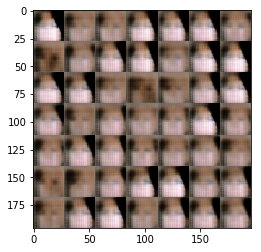

Epoch 1/1, batch 272: gen_loss=2.3006 disc_loss=0.8493
Epoch 1/1, batch 288: gen_loss=1.9632 disc_loss=0.9498
Epoch 1/1, batch 304: gen_loss=1.5197 disc_loss=1.0575
Epoch 1/1, batch 320: gen_loss=1.4253 disc_loss=1.0777
Epoch 1/1, batch 336: gen_loss=1.8962 disc_loss=1.0594
Epoch 1/1, batch 352: gen_loss=1.6762 disc_loss=1.1526
Epoch 1/1, batch 368: gen_loss=1.7457 disc_loss=1.1721
Epoch 1/1, batch 384: gen_loss=1.2819 disc_loss=1.1232


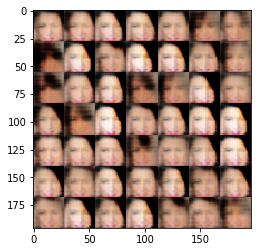

Epoch 1/1, batch 400: gen_loss=2.1884 disc_loss=1.0404
Epoch 1/1, batch 416: gen_loss=2.0051 disc_loss=1.0197
Epoch 1/1, batch 432: gen_loss=1.6825 disc_loss=0.7920
Epoch 1/1, batch 448: gen_loss=1.7043 disc_loss=0.8820
Epoch 1/1, batch 464: gen_loss=2.1818 disc_loss=1.0431
Epoch 1/1, batch 480: gen_loss=2.0058 disc_loss=0.8962
Epoch 1/1, batch 496: gen_loss=1.3961 disc_loss=1.1806
Epoch 1/1, batch 512: gen_loss=2.5692 disc_loss=1.0419


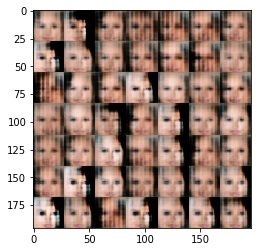

Epoch 1/1, batch 528: gen_loss=1.6233 disc_loss=1.0864
Epoch 1/1, batch 544: gen_loss=1.3484 disc_loss=0.9964
Epoch 1/1, batch 560: gen_loss=1.4218 disc_loss=1.1725
Epoch 1/1, batch 576: gen_loss=1.3569 disc_loss=1.0906
Epoch 1/1, batch 592: gen_loss=1.7821 disc_loss=1.1906
Epoch 1/1, batch 608: gen_loss=1.0889 disc_loss=1.2043
Epoch 1/1, batch 624: gen_loss=2.0732 disc_loss=1.0271
Epoch 1/1, batch 640: gen_loss=1.7177 disc_loss=1.0106


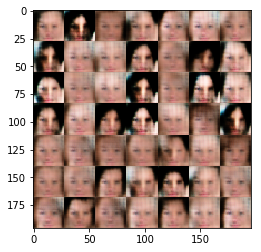

Epoch 1/1, batch 656: gen_loss=2.1526 disc_loss=1.0456
Epoch 1/1, batch 672: gen_loss=2.2616 disc_loss=1.1258
Epoch 1/1, batch 688: gen_loss=1.9914 disc_loss=1.0082
Epoch 1/1, batch 704: gen_loss=1.9514 disc_loss=0.9462
Epoch 1/1, batch 720: gen_loss=1.6934 disc_loss=1.0648
Epoch 1/1, batch 736: gen_loss=1.6957 disc_loss=0.9811
Epoch 1/1, batch 752: gen_loss=2.5607 disc_loss=1.0764
Epoch 1/1, batch 768: gen_loss=1.7842 disc_loss=1.0613


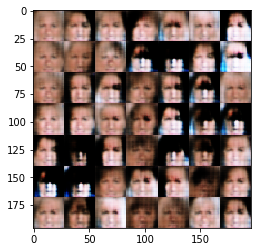

Epoch 1/1, batch 784: gen_loss=3.0211 disc_loss=1.1336
Epoch 1/1, batch 800: gen_loss=2.4299 disc_loss=1.1692
Epoch 1/1, batch 816: gen_loss=2.5419 disc_loss=1.0847
Epoch 1/1, batch 832: gen_loss=1.9768 disc_loss=1.1990
Epoch 1/1, batch 848: gen_loss=2.7571 disc_loss=1.0599
Epoch 1/1, batch 864: gen_loss=2.0764 disc_loss=1.0978
Epoch 1/1, batch 880: gen_loss=1.7846 disc_loss=1.1681
Epoch 1/1, batch 896: gen_loss=1.6879 disc_loss=1.0256


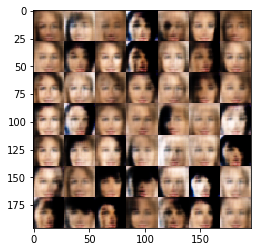

Epoch 1/1, batch 912: gen_loss=2.2712 disc_loss=1.0242
Epoch 1/1, batch 928: gen_loss=2.1836 disc_loss=1.0540
Epoch 1/1, batch 944: gen_loss=1.4477 disc_loss=1.2917
Epoch 1/1, batch 960: gen_loss=2.6673 disc_loss=1.0671
Epoch 1/1, batch 976: gen_loss=1.9087 disc_loss=1.2375
Epoch 1/1, batch 992: gen_loss=2.2966 disc_loss=0.9626
Epoch 1/1, batch 1008: gen_loss=2.0537 disc_loss=1.0964
Epoch 1/1, batch 1024: gen_loss=2.0366 disc_loss=0.9562


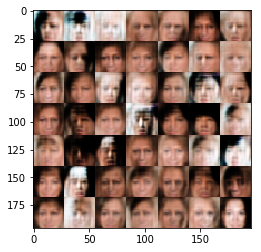

Epoch 1/1, batch 1040: gen_loss=2.7229 disc_loss=1.1956
Epoch 1/1, batch 1056: gen_loss=2.2260 disc_loss=0.9086
Epoch 1/1, batch 1072: gen_loss=3.6875 disc_loss=1.7104
Epoch 1/1, batch 1088: gen_loss=2.3291 disc_loss=0.9920
Epoch 1/1, batch 1104: gen_loss=0.6640 disc_loss=1.5495
Epoch 1/1, batch 1120: gen_loss=2.1022 disc_loss=1.0972
Epoch 1/1, batch 1136: gen_loss=2.3126 disc_loss=0.8810
Epoch 1/1, batch 1152: gen_loss=2.1545 disc_loss=0.9280


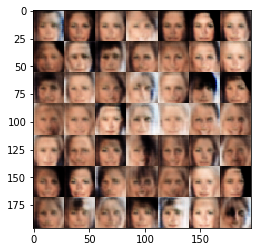

Epoch 1/1, batch 1168: gen_loss=2.2143 disc_loss=1.0406
Epoch 1/1, batch 1184: gen_loss=1.9078 disc_loss=0.8469
Epoch 1/1, batch 1200: gen_loss=1.6072 disc_loss=0.9311
Epoch 1/1, batch 1216: gen_loss=2.3596 disc_loss=0.8327
Epoch 1/1, batch 1232: gen_loss=1.7326 disc_loss=0.7674
Epoch 1/1, batch 1248: gen_loss=1.6352 disc_loss=0.8738
Epoch 1/1, batch 1264: gen_loss=2.0367 disc_loss=0.9166
Epoch 1/1, batch 1280: gen_loss=2.2333 disc_loss=1.1349


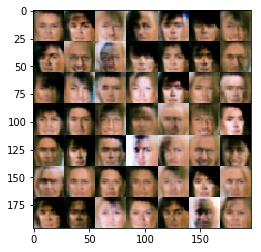

Epoch 1/1, batch 1296: gen_loss=1.1737 disc_loss=0.8911
Epoch 1/1, batch 1312: gen_loss=1.7943 disc_loss=0.8058
Epoch 1/1, batch 1328: gen_loss=1.8608 disc_loss=0.6972
Epoch 1/1, batch 1344: gen_loss=1.9949 disc_loss=0.8926
Epoch 1/1, batch 1360: gen_loss=2.1521 disc_loss=0.7269
Epoch 1/1, batch 1376: gen_loss=2.2538 disc_loss=0.5667
Epoch 1/1, batch 1392: gen_loss=1.3648 disc_loss=0.7619
Epoch 1/1, batch 1408: gen_loss=1.2406 disc_loss=0.9490


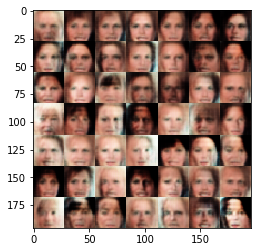

Epoch 1/1, batch 1424: gen_loss=2.8263 disc_loss=0.6333
Epoch 1/1, batch 1440: gen_loss=2.1421 disc_loss=0.7573
Epoch 1/1, batch 1456: gen_loss=1.5303 disc_loss=0.8226
Epoch 1/1, batch 1472: gen_loss=2.5206 disc_loss=0.5590
Epoch 1/1, batch 1488: gen_loss=1.7543 disc_loss=0.7743
Epoch 1/1, batch 1504: gen_loss=1.9484 disc_loss=0.6773
Epoch 1/1, batch 1520: gen_loss=1.9339 disc_loss=0.6474
Epoch 1/1, batch 1536: gen_loss=1.5527 disc_loss=0.7069


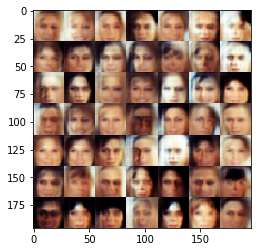

Epoch 1/1, batch 1552: gen_loss=2.0655 disc_loss=0.6686
Epoch 1/1, batch 1568: gen_loss=2.5382 disc_loss=0.5269
Epoch 1/1, batch 1584: gen_loss=2.1536 disc_loss=0.6730
Epoch 1/1, batch 1600: gen_loss=2.4432 disc_loss=0.6246
Epoch 1/1, batch 1616: gen_loss=1.3726 disc_loss=1.4556
Epoch 1/1, batch 1632: gen_loss=2.2987 disc_loss=0.5554
Epoch 1/1, batch 1648: gen_loss=2.3565 disc_loss=0.9207
Epoch 1/1, batch 1664: gen_loss=3.1240 disc_loss=0.7324


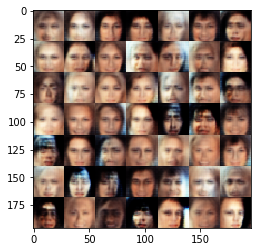

Epoch 1/1, batch 1680: gen_loss=2.4303 disc_loss=0.6270
Epoch 1/1, batch 1696: gen_loss=2.7147 disc_loss=0.5756
Epoch 1/1, batch 1712: gen_loss=2.1381 disc_loss=0.7466
Epoch 1/1, batch 1728: gen_loss=3.3808 disc_loss=0.5916
Epoch 1/1, batch 1744: gen_loss=2.2982 disc_loss=0.7096
Epoch 1/1, batch 1760: gen_loss=1.9522 disc_loss=0.6572
Epoch 1/1, batch 1776: gen_loss=2.6337 disc_loss=1.0939
Epoch 1/1, batch 1792: gen_loss=2.7365 disc_loss=0.5219


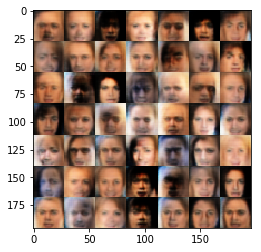

Epoch 1/1, batch 1808: gen_loss=2.7920 disc_loss=0.7350
Epoch 1/1, batch 1824: gen_loss=2.2890 disc_loss=0.9404
Epoch 1/1, batch 1840: gen_loss=2.9046 disc_loss=0.5664
Epoch 1/1, batch 1856: gen_loss=2.4437 disc_loss=0.6562
Epoch 1/1, batch 1872: gen_loss=2.2655 disc_loss=0.6767
Epoch 1/1, batch 1888: gen_loss=1.9014 disc_loss=0.5938
Epoch 1/1, batch 1904: gen_loss=2.1203 disc_loss=0.7239
Epoch 1/1, batch 1920: gen_loss=2.3298 disc_loss=0.6078


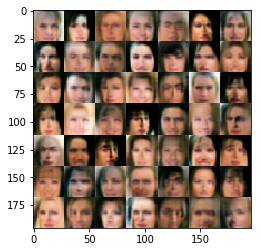

Epoch 1/1, batch 1936: gen_loss=1.9272 disc_loss=0.6488
Epoch 1/1, batch 1952: gen_loss=2.4756 disc_loss=0.7111
Epoch 1/1, batch 1968: gen_loss=2.1969 disc_loss=0.6592
Epoch 1/1, batch 1984: gen_loss=3.1139 disc_loss=0.7000
Epoch 1/1, batch 2000: gen_loss=1.5431 disc_loss=0.8863
Epoch 1/1, batch 2016: gen_loss=1.7789 disc_loss=0.5695
Epoch 1/1, batch 2032: gen_loss=2.9504 disc_loss=1.1213
Epoch 1/1, batch 2048: gen_loss=1.6081 disc_loss=0.6861


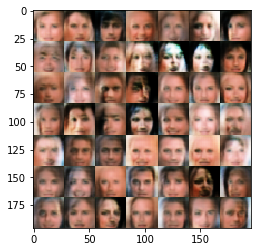

Epoch 1/1, batch 2064: gen_loss=2.8660 disc_loss=0.5776
Epoch 1/1, batch 2080: gen_loss=2.1458 disc_loss=0.9633
Epoch 1/1, batch 2096: gen_loss=2.9358 disc_loss=0.6473
Epoch 1/1, batch 2112: gen_loss=3.5256 disc_loss=0.5112
Epoch 1/1, batch 2128: gen_loss=1.5666 disc_loss=0.7661
Epoch 1/1, batch 2144: gen_loss=3.0133 disc_loss=0.9545
Epoch 1/1, batch 2160: gen_loss=2.4378 disc_loss=0.5653
Epoch 1/1, batch 2176: gen_loss=2.0579 disc_loss=0.6445


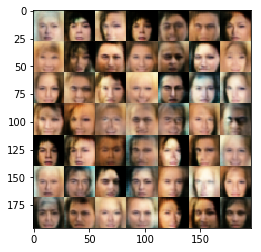

Epoch 1/1, batch 2192: gen_loss=2.3525 disc_loss=0.5866
Epoch 1/1, batch 2208: gen_loss=3.6619 disc_loss=0.7438
Epoch 1/1, batch 2224: gen_loss=2.2571 disc_loss=1.0405
Epoch 1/1, batch 2240: gen_loss=2.0242 disc_loss=0.6483
Epoch 1/1, batch 2256: gen_loss=3.0389 disc_loss=0.7995
Epoch 1/1, batch 2272: gen_loss=1.9869 disc_loss=1.0048
Epoch 1/1, batch 2288: gen_loss=3.2676 disc_loss=0.5087
Epoch 1/1, batch 2304: gen_loss=2.6462 disc_loss=0.7495


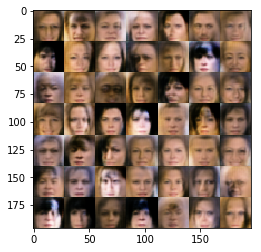

Epoch 1/1, batch 2320: gen_loss=2.0921 disc_loss=0.7319
Epoch 1/1, batch 2336: gen_loss=3.5888 disc_loss=0.7146
Epoch 1/1, batch 2352: gen_loss=2.0240 disc_loss=0.7339
Epoch 1/1, batch 2368: gen_loss=3.3176 disc_loss=0.5757
Epoch 1/1, batch 2384: gen_loss=2.9760 disc_loss=0.5324
Epoch 1/1, batch 2400: gen_loss=2.1399 disc_loss=0.7577
Epoch 1/1, batch 2416: gen_loss=1.3028 disc_loss=1.1232
Epoch 1/1, batch 2432: gen_loss=1.9201 disc_loss=0.6250


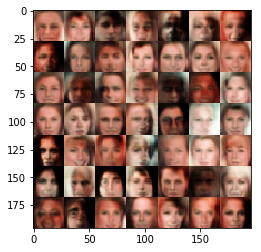

Epoch 1/1, batch 2448: gen_loss=2.6805 disc_loss=0.7094
Epoch 1/1, batch 2464: gen_loss=2.9900 disc_loss=0.8272
Epoch 1/1, batch 2480: gen_loss=2.3941 disc_loss=0.6918
Epoch 1/1, batch 2496: gen_loss=3.2235 disc_loss=0.5014
Epoch 1/1, batch 2512: gen_loss=1.9044 disc_loss=0.9356
Epoch 1/1, batch 2528: gen_loss=2.0027 disc_loss=0.6873
Epoch 1/1, batch 2544: gen_loss=2.2820 disc_loss=0.6848
Epoch 1/1, batch 2560: gen_loss=2.4006 disc_loss=0.7483


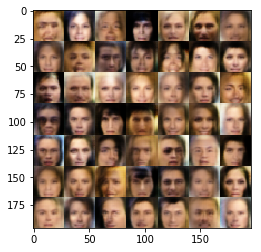

Epoch 1/1, batch 2576: gen_loss=2.2883 disc_loss=0.5855
Epoch 1/1, batch 2592: gen_loss=2.0117 disc_loss=0.7335
Epoch 1/1, batch 2608: gen_loss=3.2353 disc_loss=0.6845
Epoch 1/1, batch 2624: gen_loss=3.5168 disc_loss=0.5971
Epoch 1/1, batch 2640: gen_loss=2.8730 disc_loss=0.5992
Epoch 1/1, batch 2656: gen_loss=2.1319 disc_loss=0.6176
Epoch 1/1, batch 2672: gen_loss=2.0566 disc_loss=0.6186
Epoch 1/1, batch 2688: gen_loss=2.5630 disc_loss=0.6055


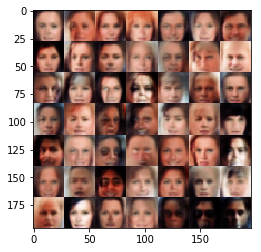

Epoch 1/1, batch 2704: gen_loss=2.4248 disc_loss=0.5853
Epoch 1/1, batch 2720: gen_loss=2.4949 disc_loss=0.6883
Epoch 1/1, batch 2736: gen_loss=2.4319 disc_loss=0.5052
Epoch 1/1, batch 2752: gen_loss=2.8459 disc_loss=0.6276
Epoch 1/1, batch 2768: gen_loss=2.3984 disc_loss=0.6106
Epoch 1/1, batch 2784: gen_loss=3.6862 disc_loss=0.5866
Epoch 1/1, batch 2800: gen_loss=3.0951 disc_loss=0.5845
Epoch 1/1, batch 2816: gen_loss=1.9813 disc_loss=0.8323


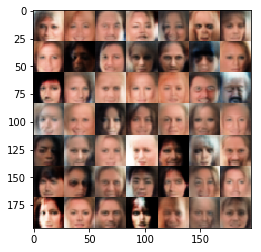

Epoch 1/1, batch 2832: gen_loss=2.0465 disc_loss=0.6958
Epoch 1/1, batch 2848: gen_loss=2.5617 disc_loss=0.6817
Epoch 1/1, batch 2864: gen_loss=2.6197 disc_loss=0.6975
Epoch 1/1, batch 2880: gen_loss=2.3284 disc_loss=0.5526
Epoch 1/1, batch 2896: gen_loss=3.5993 disc_loss=1.0184
Epoch 1/1, batch 2912: gen_loss=2.6873 disc_loss=0.6578
Epoch 1/1, batch 2928: gen_loss=2.4957 disc_loss=0.5308
Epoch 1/1, batch 2944: gen_loss=2.0687 disc_loss=0.6473


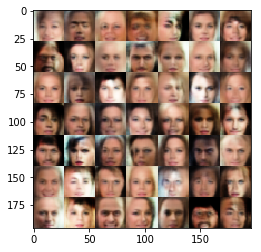

Epoch 1/1, batch 2960: gen_loss=2.3928 disc_loss=0.5787
Epoch 1/1, batch 2976: gen_loss=3.2026 disc_loss=0.5465
Epoch 1/1, batch 2992: gen_loss=3.4625 disc_loss=0.5478
Epoch 1/1, batch 3008: gen_loss=3.5768 disc_loss=0.9241
Epoch 1/1, batch 3024: gen_loss=2.7579 disc_loss=0.5521
Epoch 1/1, batch 3040: gen_loss=3.7102 disc_loss=1.0025
Epoch 1/1, batch 3056: gen_loss=1.8018 disc_loss=0.7342
Epoch 1/1, batch 3072: gen_loss=1.9633 disc_loss=0.7538


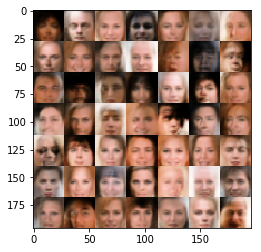

Epoch 1/1, batch 3088: gen_loss=1.8267 disc_loss=0.6882
Epoch 1/1, batch 3104: gen_loss=2.1069 disc_loss=0.8181
Epoch 1/1, batch 3120: gen_loss=3.4282 disc_loss=0.7652
Epoch 1/1, batch 3136: gen_loss=2.3908 disc_loss=0.6258
Epoch 1/1, batch 3152: gen_loss=3.6533 disc_loss=0.6227
Epoch 1/1, batch 3165: gen_loss=3.6533 disc_loss=0.6227
TRAINING COMPLETE.


In [25]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.